In [1]:
import sys
sys.path.append('..')
from MPRA_predict.utils import *

In [2]:
df = pd.read_excel('../data/Deng_MPRA/adh0559_data_s1.xlsx', sheet_name='Primary')
df

,insert_chrom,insert_start,insert_end,insert_name,rna_dna_ratio,is_silencer,is_active,overlaps_atac_AstroOligo,overlaps_atac_dlEN,overlaps_atac_earlyEN,overlaps_atac_EndoMural,overlaps_atac_IN_CGE,overlaps_atac_IN_MGE,overlaps_atac_IPC,overlaps_atac_Microglia,overlaps_atac_RG,overlaps_atac_ulEN,overlaps_da_AstroOligo,overlaps_da_dlEN,overlaps_da_earlyEN,overlaps_da_EndoMural,overlaps_da_IN_CGE,overlaps_da_IN_MGE,overlaps_da_IPC,overlaps_da_Microglia,overlaps_da_RG,overlaps_da_ulEN,overlaps_k27ac_microglia,overlaps_k27ac_nonmicroglia,overlaps_k27ac_pfc_15gw,motif_total_usf,motif_total_all,overlaps_placseq_loop,overlaps_pchic_loop,looping_promoters_placseq_excitatory_neurons,looping_promoters_placseq_intermediate_progenitor_cells,looping_promoters_placseq_interneurons,looping_promoters_placseq_radial_glia,looping_promoters_pchic_astrocytes,looping_promoters_pchic_cortical_excitatory_neurons,looping_promoters_pchic_hippocampal_neurons,looping_promoters_pchic_lower_motor_neurons,abc_target_gene_name_AstroOligo,abc_target_gene_name_dlEN,abc_target_gene_name_earlyEN,abc_target_gene_name_EndoMural,abc_target_gene_name_IN_CGE,abc_target_gene_name_IN_MGE,abc_target_gene_name_IPC,abc_target_gene_name_Microglia,abc_target_gene_name_RG,abc_target_gene_name_ulEN,insert_conservation_mean
0,chr10,100006370,100006640,chr10:100006370-100006640,0.932,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,1,NaN,"ABCC2,DNMBP",NaN,"ABCC2,DNMBP","ABCC2,DNMBP",ABCC2,"ABCC2,DNMBP","ABCC2,DNMBP",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.096
1,chr10,100136626,100136896,chr10:100136626-100136896,1.109,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,ABCC2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.180
2,chr10,100192387,100192657,chr10:100192387-100192657,1.051,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.565
3,chr10,100314136,100314406,chr10:100314136-100314406,0.529,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,"BLOC1S2,CWF19L1","BLOC1S2,CWF19L1,SCD",NaN,SCD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.171
4,chr10,100326976,100327246,chr10:100326976-100327246,1.004,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,1,NaN,NaN,NaN,NaN,"BLOC1S2,CWF19L1",NaN,NaN,SCD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SCD,NaN,NaN,-0.016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46365,chrY,7817280,7817550,chrY:7817280-7817550,0.618,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.359
46366,chrY,7820804,7821074,chrY:7820804-7821074,1.518,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.067
46367,chrY,7825904,7826174,chrY:7825904-7826174,0.995,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.126
46368,chrY,7873494,7873764,chrY:7873494-7873764,1.997,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.265


In [3]:
df = df[['insert_name', 'rna_dna_ratio']]
df = df.rename(columns={'insert_name': 'seq_id'})
df

,seq_id,rna_dna_ratio
0,chr10:100006370-100006640,0.932
1,chr10:100136626-100136896,1.109
2,chr10:100192387-100192657,1.051
3,chr10:100314136-100314406,0.529
4,chr10:100326976-100327246,1.004
...,...,...
46365,chrY:7817280-7817550,0.618
46366,chrY:7820804-7821074,1.518
46367,chrY:7825904-7826174,0.995
46368,chrY:7873494-7873764,1.997


In [4]:
df['activity'] = np.log2(df['rna_dna_ratio'])
mean = np.mean(df['activity'])
std = np.std(df['activity'])
df['activity'] = (df['activity'] - mean) / std
df

,seq_id,rna_dna_ratio,activity
0,chr10:100006370-100006640,0.932,-0.094
1,chr10:100136626-100136896,1.109,0.336
2,chr10:100192387-100192657,1.051,0.203
3,chr10:100314136-100314406,0.529,-1.491
4,chr10:100326976-100327246,1.004,0.090
...,...,...,...
46365,chrY:7817280-7817550,0.618,-1.109
46366,chrY:7820804-7821074,1.518,1.112
46367,chrY:7825904-7826174,0.995,0.068
46368,chrY:7873494-7873764,1.997,1.790


In [5]:
df[['chr', 'pos']] = df['seq_id'].str.split(':', expand=True)
df[['start', 'end']] = df['pos'].str.split('-', expand=True)
df = df.drop(columns=['pos'])
df

,seq_id,rna_dna_ratio,activity,chr,start,end
0,chr10:100006370-100006640,0.932,-0.094,chr10,100006370,100006640
1,chr10:100136626-100136896,1.109,0.336,chr10,100136626,100136896
2,chr10:100192387-100192657,1.051,0.203,chr10,100192387,100192657
3,chr10:100314136-100314406,0.529,-1.491,chr10,100314136,100314406
4,chr10:100326976-100327246,1.004,0.090,chr10,100326976,100327246
...,...,...,...,...,...,...
46365,chrY:7817280-7817550,0.618,-1.109,chrY,7817280,7817550
46366,chrY:7820804-7821074,1.518,1.112,chrY,7820804,7821074
46367,chrY:7825904-7826174,0.995,0.068,chrY,7825904,7826174
46368,chrY:7873494-7873764,1.997,1.790,chrY,7873494,7873764


In [6]:
from pyfaidx import Fasta

genome = Fasta('../../../genome/hg38.fa')

In [7]:
def get_sequence(row):
    chrom = row['chr']
    start = int(row['start'])
    end = int(row['end'])
    try:
        seq = genome[chrom][start:end].seq  # 注意：pyfaidx 是0-based, end不包含
        return seq.upper()
    except KeyError:
        return "N" * (end - start)

df["seq"] = df.apply(get_sequence, axis=1)
df

,seq_id,rna_dna_ratio,activity,chr,start,end,seq
0,chr10:100006370-100006640,0.932,-0.094,chr10,100006370,100006640,AAAACTTAAAATTCTTGAGCTAGAGAGGGCCCAGTTATTTTACAGA...
1,chr10:100136626-100136896,1.109,0.336,chr10,100136626,100136896,GTGTCTCTCGTGCGTGCTTTCTGGCTGTGTGTTATGATACAGCAAG...
2,chr10:100192387-100192657,1.051,0.203,chr10,100192387,100192657,CATTGGGCCACATGTATAATGACCCCAAGATATATACCCTGGAACT...
3,chr10:100314136-100314406,0.529,-1.491,chr10,100314136,100314406,ACAGAAACTATGTTATCACCACTTGGAAGGGTATGAAATTCCTGAA...
4,chr10:100326976-100327246,1.004,0.090,chr10,100326976,100327246,ATTCAAACAGTTGAAAGGTTGTCACTTCAGAGAGTAACAGGAACAC...
...,...,...,...,...,...,...,...
46365,chrY:7817280-7817550,0.618,-1.109,chrY,7817280,7817550,TCCTACAGAAGTCCTGGTTTCATGTATGTAATTTCACTCTCTATGA...
46366,chrY:7820804-7821074,1.518,1.112,chrY,7820804,7821074,TGATCATTATGCCTTTGAAATGAATCACAGTATATGTTCTAATCCC...
46367,chrY:7825904-7826174,0.995,0.068,chrY,7825904,7826174,GAATAACTTTTATATTCTAATCAAACCAAATTGAATATTTAGAAAT...
46368,chrY:7873494-7873764,1.997,1.790,chrY,7873494,7873764,TGGCAAAGGTAGATATCACAATCCCATATATGAGCTGGAATAAATC...


<Axes: xlabel='activity', ylabel='Count'>

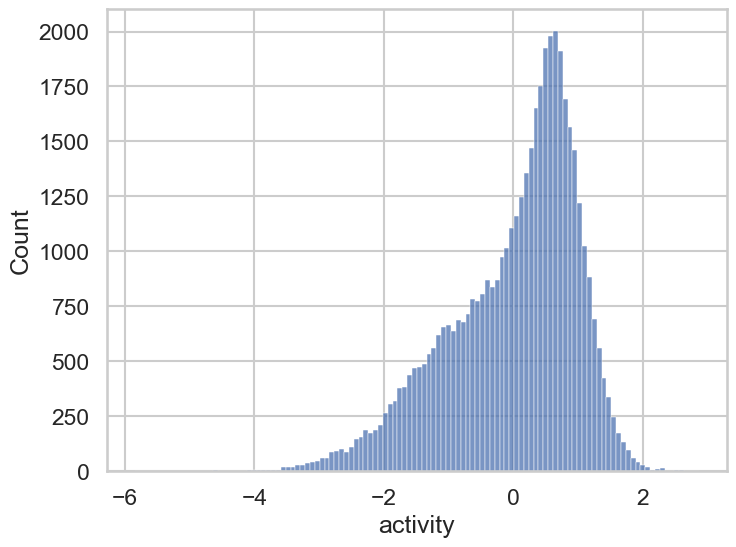

In [8]:
sns.histplot(df['activity'])

In [9]:
df.to_csv("../data/Deng_MPRA/Deng_MPRA.csv", index=False)